In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [3]:
import torch
from transformers import (
    BertForMaskedLM,
    BertTokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback,
    pipeline,
    AutoTokenizer,
    AutoModelForMaskedLM,
)
from datasets import Dataset, load_dataset
import pandas as pd
import random
import numpy as np


In [ ]:
# ========================
# 1. Configuration
# ========================
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
MODEL_NAME = "DeepPavlov/rubert-base-cased"

MAX_SEQ_LENGTH = 256
TRAIN_RATIO = 0.85

In [ ]:
gazetta_df = pd.read_csv("/content/Газет_ру-финансовые-новости.csv")
rbk_df = pd.read_csv("/content/РБК-финансовые-новости.csv")
stockNews_df = pd.read_csv("/content/englishFinancialNews.csv")
print(f"Gazetta shape: {gazetta_df.shape}, RBK shape: {rbk_df.shape}, Stock News shape: {stockNews_df.shape}\n")
print("Gazetta info: \n", gazetta_df.info())
print("RBK info: \n", rbk_df.info())
print("Stock News info: \n", stockNews_df.info())

Gazetta shape: (10937, 7), RBK shape: (16517, 6), Stock News shape: (11606, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10937 entries, 0 to 10936
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10937 non-null  int64 
 1   text        10937 non-null  object
 2   summary     10937 non-null  object
 3   title       10937 non-null  object
 4   date        10937 non-null  object
 5   url         10937 non-null  object
 6   category    10937 non-null  object
dtypes: int64(1), object(6)
memory usage: 598.2+ KB
Gazetta info: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16517 entries, 0 to 16516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16517 non-null  int64 
 1   url         16517 non-null  object
 2   date        16517 non-null  object
 3   title       16517 non-null  object
 4   category    16517 non-null

In [9]:
stockNews_df.rename(columns={"title":"text"}, inplace=True)
df1_text = gazetta_df[['text']]
df2_text = rbk_df[['text']]
df3_text = stockNews_df[['text']]

# Concatenate the DataFrames along the rows
df = pd.concat([df1_text, df2_text, df3_text], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
print(df.info())

(39060, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39060 entries, 0 to 39059
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39060 non-null  object
dtypes: object(1)
memory usage: 305.3+ KB
None


In [10]:
df.head()

,text
0,В среду была опубликована финансовая отчетност...
1,Benzinga Pro Morning Price Check For Regional ...
2,Russia's Novak Says OPEC And Non-OPEC Countrie...
3,Федеральная резервная система (ФРС) США сохран...
4,Первый торговый день после пятничных санкций п...


In [11]:
dataset = Dataset.from_pandas(df[["text"]])

In [ ]:
# ========================
# 4. Tokenization Setup
# ========================
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_special_tokens_mask=True  # Helps data collator
    )

tokenized_ds = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
split_ds = tokenized_ds.train_test_split(test_size=1-TRAIN_RATIO, seed=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Map:   0%|          | 0/39060 [00:00<?, ? examples/s]

In [ ]:
original_vocab_size = tokenizer.vocab_size  # ~120,000

# Embedding layer shape before/after:
print(f"Original: {original_vocab_size} x 768")

Original: 119547 x 768


In [14]:
# ========================
# 5. Model Initialization
# ========================
model = BertForMaskedLM.from_pretrained(MODEL_NAME)
# model.resize_token_embeddings(len(tokenizer))

# Smart layer freezing: Unfreeze embeddings + last 3 layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze embeddings
for param in model.bert.embeddings.parameters():
    param.requires_grad = True

# Unfreeze last 1 transformer layer
for layer in model.bert.encoder.layer[-5:]:
    for param in layer.parameters():
        param.requires_grad = True
# Unfreeze the MLM head (cls.predictions)
    for param in model.cls.predictions.parameters():
        param.requires_grad = True
for name, param in model.named_parameters():
    print(f"{name} - Trainable: {param.requires_grad}")

# # Initialize new embeddings (if terms added)
# if len(FINANCIAL_TERMS) > 0:
#     initialize_new_embeddings(model, tokenizer, FINANCIAL_TERMS)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


bert.embeddings.word_embeddings.weight - Trainable: True
bert.embeddings.position_embeddings.weight - Trainable: True
bert.embeddings.token_type_embeddings.weight - Trainable: True
bert.embeddings.LayerNorm.weight - Trainable: True
bert.embeddings.LayerNorm.bias - Trainable: True
bert.encoder.layer.0.attention.self.query.weight - Trainable: False
bert.encoder.layer.0.attention.self.query.bias - Trainable: False
bert.encoder.layer.0.attention.self.key.weight - Trainable: False
bert.encoder.layer.0.attention.self.key.bias - Trainable: False
bert.encoder.layer.0.attention.self.value.weight - Trainable: False
bert.encoder.layer.0.attention.self.value.bias - Trainable: False
bert.encoder.layer.0.attention.output.dense.weight - Trainable: False
bert.encoder.layer.0.attention.output.dense.bias - Trainable: False
bert.encoder.layer.0.attention.output.LayerNorm.weight - Trainable: False
bert.encoder.layer.0.attention.output.LayerNorm.bias - Trainable: False
bert.encoder.layer.0.intermediate.den

In [15]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
# ========================
# 6. Training Setup
# ========================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
    pad_to_multiple_of=8  # Optimizes GPU utilization
)

training_args = TrainingArguments(
    output_dir="./rubert-mlm",
    logging_dir="./logs",
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Reduced from 64
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=250,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,  # Better than fixed steps
    lr_scheduler_type="inverse_sqrt", # so far this gives the lowest loss
    gradient_accumulation_steps=2,
    fp16=True,
    report_to="tensorboard",
    save_total_limit=2,
    load_best_model_at_end=False,
    metric_for_best_model="eval_loss",
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    data_collator=data_collator,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# ========================
# 7. Baseline Model Evaluation
# ========================
# Initialize fresh model for baseline (don't freeze layers yet)
baseline_model = BertForMaskedLM.from_pretrained(MODEL_NAME)

# Evaluate baseline
trainer_baseline = Trainer(
    model=baseline_model,
    args=TrainingArguments(output_dir="./tmp", report_to="none"),
    data_collator=data_collator,
)
baseline_results = trainer_baseline.evaluate(eval_dataset=split_ds["test"])
baseline_perplexity = torch.exp(torch.tensor(baseline_results["eval_loss"])).item()
print(f"Baseline Perplexity (Pre-Fine-Tuning): {baseline_perplexity:.2f}")

Baseline Perplexity (Pre-Fine-Tuning): 5.65


In [18]:
fill_mask = pipeline("fill-mask", model=baseline_model, tokenizer=tokenizer)
print(fill_mask("Revenue grew by [MASK]% this quarter."))

Device set to use cuda:0


[{'score': 0.09697891026735306, 'token': 7993, 'token_str': '100', 'sequence': 'Revenue grew by 100 % this quarter.'}, {'score': 0.06743824481964111, 'token': 11431, 'token_str': '90', 'sequence': 'Revenue grew by 90 % this quarter.'}, {'score': 0.04616888239979744, 'token': 10749, 'token_str': '80', 'sequence': 'Revenue grew by 80 % this quarter.'}, {'score': 0.04545310139656067, 'token': 10602, 'token_str': '70', 'sequence': 'Revenue grew by 70 % this quarter.'}, {'score': 0.04106345400214195, 'token': 12490, 'token_str': '95', 'sequence': 'Revenue grew by 95 % this quarter.'}]


In [19]:
fill_mask = pipeline("fill-mask", model=baseline_model, tokenizer=tokenizer)
print(fill_mask("\"Юнипро\" [MASK] выработку электроэнергии в 1 полугодии на 17,1%"))

Device set to use cuda:0


[{'score': 0.3490051329135895, 'token': 72361, 'token_str': 'увеличила', 'sequence': '" Юнипро " увеличила выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.24748170375823975, 'token': 50581, 'token_str': 'увеличил', 'sequence': '" Юнипро " увеличил выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.06160306558012962, 'token': 74575, 'token_str': 'повысил', 'sequence': '" Юнипро " повысил выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.03455618768930435, 'token': 71163, 'token_str': 'снизил', 'sequence': '" Юнипро " снизил выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.02528184838593006, 'token': 107640, 'token_str': 'снизила', 'sequence': '" Юнипро " снизила выработку электроэнергии в 1 полугодии на 17, 1 %'}]


In [20]:
# ========================
# 8. Training & Evaluation
# ========================
train_results = trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss,Validation Loss
500,1.644600,1.495443
1000,1.558100,1.424067
1500,1.520000,1.403112
2000,1.481100,1.371077
2500,1.464400,1.372788
3000,1.451200,1.359176
3500,1.424100,1.360905
4000,1.417500,1.353253
4500,1.408700,1.331662
5000,1.410200,1.326084


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

In [21]:
# Calculate final perplexity
eval_results = trainer.evaluate()
perplexity = torch.exp(torch.tensor(eval_results["eval_loss"])).item()
print(f"Final Perplexity: {perplexity:.2f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Final Perplexity: 3.75


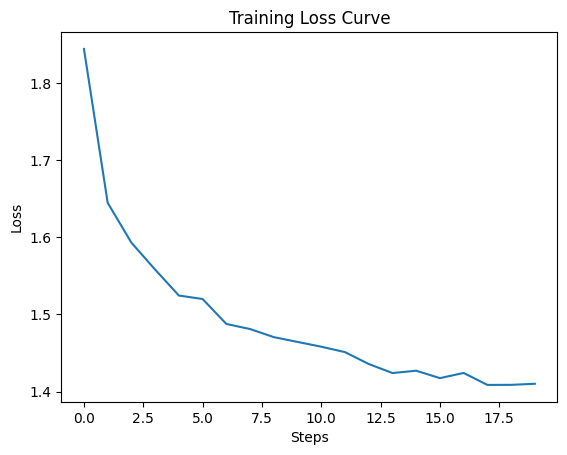

In [22]:
import matplotlib.pyplot as plt
# ========================
# 9. Monitoring (Optional)
# ========================
# Plot training loss
if trainer.state.log_history:
    train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
    plt.plot(train_loss)
    plt.title("Training Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.show()
else:
    print("No training loss data to plot!")

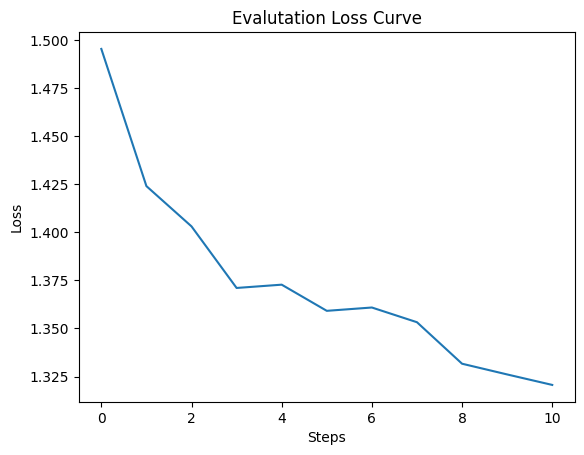

In [23]:
if trainer.state.log_history:
    train_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    plt.plot(train_loss)
    plt.title("Evalutation Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.show()
else:
    print("No training loss data to plot!")

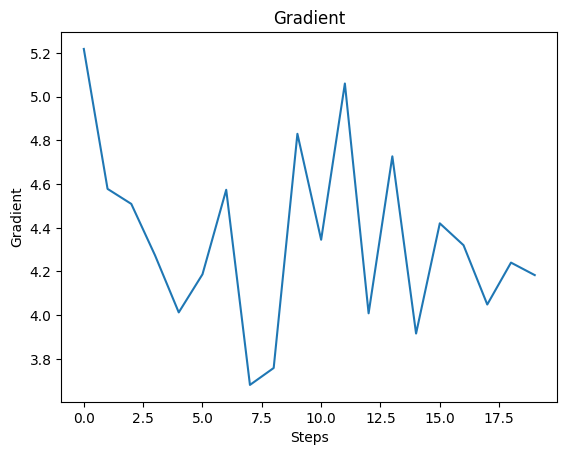

In [24]:
if trainer.state.log_history:
    train_loss = [log["grad_norm"] for log in trainer.state.log_history if "grad_norm" in log]
    plt.plot(train_loss)
    plt.title("Gradient")
    plt.xlabel("Steps")
    plt.ylabel("Gradient")
    plt.show()
else:
    print("No training loss data to plot!")

In [25]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)
fill_mask_base = pipeline("fill-mask", model=baseline_model, tokenizer=tokenizer)
print(fill_mask("Revenue grew by [MASK]% this quarter."))
print("=+="*100)
print(tokenizer.tokenize("«Газпром» сообщил о росте объема поставок в Китай на 60%"))
print("=+="*100)
print(fill_mask("«Газпром» сообщил о [MASK] объема поставок в Китай на 60%"))
print("=+="*100)
print(fill_mask_base("«Газпром» сообщил о [MASK] объема поставок в Китай на 60%"))

Device set to use cuda:0
Device set to use cuda:0


[{'score': 0.053217921406030655, 'token': 10749, 'token_str': '80', 'sequence': 'Revenue grew by 80 % this quarter.'}, {'score': 0.040328219532966614, 'token': 3955, 'token_str': '10', 'sequence': 'Revenue grew by 10 % this quarter.'}, {'score': 0.04001438245177269, 'token': 10602, 'token_str': '70', 'sequence': 'Revenue grew by 70 % this quarter.'}, {'score': 0.0344945564866066, 'token': 7553, 'token_str': '50', 'sequence': 'Revenue grew by 50 % this quarter.'}, {'score': 0.03140764683485031, 'token': 5345, 'token_str': '30', 'sequence': 'Revenue grew by 30 % this quarter.'}]
=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=
['«', 'Газпром', '»', 'сообщил', 'о', 'росте', 'объема', 'поставок', 'в', 'Китай', 'на', '60', '%']
=+==+==+==+==+=

In [26]:
trainer.save_model("./rubert-mlm/rubert_finetuned_5_embad_layers")
tokenizer.save_pretrained("./rubert-mlm/rubert_finetuned_5_embad_layers")

('./rubert-mlm/rubert_finetuned_5_embad_layers/tokenizer_config.json',
 './rubert-mlm/rubert_finetuned_5_embad_layers/special_tokens_map.json',
 './rubert-mlm/rubert_finetuned_5_embad_layers/vocab.txt',
 './rubert-mlm/rubert_finetuned_5_embad_layers/added_tokens.json',
 './rubert-mlm/rubert_finetuned_5_embad_layers/tokenizer.json')